In [47]:
default_installations = True
if default_installations:
    !pip -q install transformers==4.28.0 datasets num2words autocorrect accelerate evaluate
else:
    import requests

    text_file_path = "requirements__Ch6_Text_Classification_DL.txt"
    url = "https://raw.githubusercontent.com/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs/main/Chapter6_notebooks/" + text_file_path
    res = requests.get(url)
    with open(text_file_path, "w") as f:
        f.write(res.text)

    !pip install -r requirements__Ch6_Text_Classification_DL.txt

  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [62 lines of output]
      /private/var/folders/3g/9z2y6vy916ncn7tzc7rkg8140000gn/T/pip-build-env-xjg861z6/overlay/lib/python3.12/site-packages/setuptools/dist.py:759: SetuptoolsDeprecationWarning: License classifiers are deprecated.
      !!
      
              ********************************************************************************
              Please consider removing the following classifiers in favor of a SPDX license expression:
      
              License :: OSI Approved :: Apache Software License
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
              ********************************************************************************
      
      !!
        self._finalize_license_expression()
      running bdist_wheel
      running build
      running build_p

In [48]:
import numpy as np
import pandas as pd
import matplotlib
import scipy
import re
from datasets import load_dataset, Dataset
from num2words import num2words
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer, TrainingArguments, Trainer
from torch.utils.data import DataLoader
import evaluate

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/llouis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/llouis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/llouis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [49]:
!pip install -Uq koreanize-matplotlib
import koreanize_matplotlib

In [50]:
config_dict = {'source_of_dataset': "json",
               'json_url': "https://huggingface.co/datasets/medalpaca/medical_meadow_health_advice/raw/main/medical_meadow_health_advice.json",
               'db_name': "medalpaca/medical_meadow_health_advice",
               'do_preprocessing': True,
               'do_enhanced_preprocessing': False,
               'do_feature_eng': True,
               'maximize_a_priori': False,
               'num_chosen_features_per_class': 200,
               'test_size': 0.25,
               'feature_eng_details': "CountVectorizer-binary",
               'ngram_range_min': 1,
               'ngram_range_max': 3,
               'max_features': 1000,
               'seed': 0}
lm_training_args = TrainingArguments(
    output_dir="test_trainer",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    learning_rate=2e-5,
    eval_strategy="steps",
    logging_steps=100,
    report_to="none")
layers_to_fine_tune = None
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [51]:
if config_dict["source_of_dataset"] == "datasets package":
    dataset_raw = load_dataset(config_dict["db_name"])
    dataset_df = pd.DataFrame(dataset_raw["train"])
elif config_dict["source_of_dataset"] == "json":
    dataset_df = pd.read_json(config_dict["json_url"])

In [52]:
dataset_df["_label_"] = dataset_df["output"]
dataset_df["text"] = dataset_df["input"]
dataset_df = dataset_df[["text", "_label_"]]

In [53]:
dataset_df.head(4).style.set_properties(**{'text-align': 'left'})

,text,_label_
0,"As we have previously shown an additional effect of vibrating insoles on improving static balance [3–5], it is possible that the combined effect on balance and gait will have a greater impact on falls and mobility than our data would imply.",This is no advice
1,"Furthermore, gut microbiota analysis in mice treated with hypolipidemic drugs revealed a modification in composition in favor of probiotic-type bacteria from Lactobacillus spp. [49].",This is no advice
2,Further research is recommended that may be helpful in establishing the direction of the association.,This is no advice
3,Further study will be necessary to test if postnatal intervention can effectively promote neurodevelopmental outcomes for healthy infants with below-average white matter development at birth.,This is no advice


In [54]:
print("원래 레이블의 분포:\n")
dataset_df[["_label_"]].value_counts()

원래 레이블의 분포:



_label_                
This is no advice          6477
This is a weak advice      1338
This is a strong advice     861
Name: count, dtype: int64

In [55]:
dataset_df_binary = dataset_df.copy()
dataset_df_binary["_label_"] = dataset_df["_label_"].map({"This is no advice": 0}).fillna(1).map(int)
dataset_df_binary.head()

,text,_label_
0,"As we have previously shown an additional effect of vibrating insoles on improving static balance [3–5], it is possible that the combined effect on balance and gait will have a greater impact on falls and mobility than our data would imply.",0
1,"Furthermore, gut microbiota analysis in mice treated with hypolipidemic drugs revealed a modification in composition in favor of probiotic-type bacteria from Lactobacillus spp. [49].",0
2,Further research is recommended that may be helpful in establishing the direction of the association.,0
3,Further study will be necessary to test if postnatal intervention can effectively promote neurodevelopmental outcomes for healthy infants with below-average white matter development at birth.,0
4,"On the other hand, rheumatoid factor and Epstein Barr virus infections have been described to cause falsely elevated C. trachomatis IgM titers 10, 11.",0


In [56]:
print("새로운 레이블의 분포:\n")
frequencies = dataset_df_binary[["_label_"]].value_counts()
frequencies

새로운 레이블의 분포:



_label_
0          6477
1          2199
Name: count, dtype: int64

In [57]:
most_frequent_class = frequencies.index[:][0][0]
print("가장 빈도가 높은 클래스는:", most_frequent_class)
print("해당 클래스의 기준 정확도는:", round((dataset_df_binary["_label_"] == most_frequent_class).mean(), 3))

가장 빈도가 높은 클래스는: 0
해당 클래스의 기준 정확도는: 0.747


In [58]:
def digits_to_words(match):
    suffixes = ['st', 'nd', 'rd', 'th']
    string = match[0].lower()
    if string[-2:] in suffixes:
        type = 'ordinal'
        string = string[:-2]
    else:
        type = 'cardinal'
    return num2words(string, to=type)


def spelling_correction(text):
    corrector = Speller()
    spells = [corrector(word) for word in text.split()]
    return " ".join(spells)


def remove_stop_words(text):
    stopwords_set = set(stopwords.words('english'))
    return " ".join([word for word in text.split() if word not in stopwords_set])


def stemming(text):
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(word) for word in text.split()])


def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])


def preprocessing(input_text):
    output = input_text
    output = output.lower()
    output = re.sub(r'\d+(st)?(nd)?(rd)?(th)?', digits_to_words, output, flags=re.IGNORECASE)
    output = re.sub('[^ A-Za-z0-9]+', '', output)
    if config_dict["do_enhanced_preprocessing"]:
        output = spelling_correction(output)
    output = remove_stop_words(output)
    if config_dict["do_enhanced_preprocessing"]:
        output = stemming(output)
        output = lemmatizing(output)
    return output

In [59]:
dataset_clean = dataset_df_binary.copy()
if config_dict["do_preprocessing"]:
    dataset_clean["text"] = [preprocessing(text) for text in dataset_clean["text"]]

In [60]:
dataset_clean[["text", "_label_"]].head(10).style.set_properties(**{'text-align': 'left'})

,text,_label_
0,previously shown additional effect vibrating insoles improving static balance threefive possible combined effect balance gait greater impact falls mobility data would imply,0
1,furthermore gut microbiota analysis mice treated hypolipidemic drugs revealed modification composition favor probiotictype bacteria lactobacillus spp fortynine,0
2,research recommended may helpful establishing direction association,0
3,study necessary test postnatal intervention effectively promote neurodevelopmental outcomes healthy infants belowaverage white matter development birth,0
4,hand rheumatoid factor epstein barr virus infections described cause falsely elevated c trachomatis igm titers ten eleven,0
5,interestingly within context proposed environmental enrichment may actually mild stressor mice moncek et al two thousand four,0
6,thus failed quit reduction attempt marker increased decreased interest changing,0
7,study replicates prior findings hughes et al two thousand eight cannabis users trying change make many often rapid transitions among use usual reduction abstinence states b reduction attempts common abstinence attempts c quit reduction attempts shortlived participants achieve longterm abstinence use alcohol illicit drugs significantly increase abstinence e seek treatment,0
8,use crosssectional design limits ascertainment direction association ie possible mindfulness strategies may change symptoms social anxiety disappear strengthened mindfulness strategies may offer advantages could plausibly reduce symptoms social anxiety,0
9,fact tumor metastasis increased lungs eselectinoverexpressing mice reduced eselectin knockout mice eighteen,0


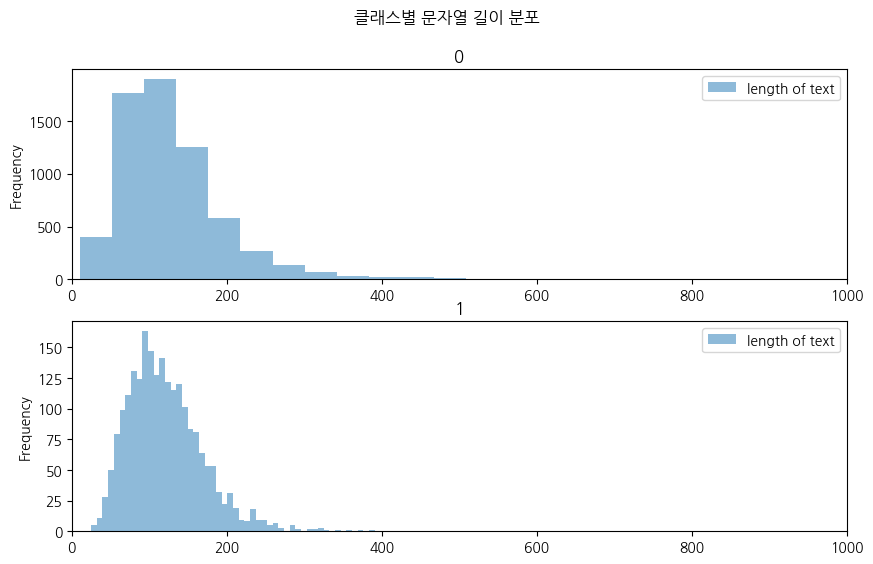

In [61]:
dataset_clean["length of text"] = dataset_clean["text"].map(len)
ax = dataset_clean.plot.hist(column=["length of text"], by="_label_",
                             bins=50, alpha=0.5, figsize=(10, 6),
                             title="클래스별 문자열 길이 분포",
                             xlim=[0, 1000])

In [62]:
def feat_eng_text_df(in_df, text_col, labels_col, config_dict):
    if "CountVectorizer-binary" == config_dict["feature_eng_details"]:
        print("특성 공학 방식: 이진 인코딩 (원-핫 인코딩)")
        countvectorizer = CountVectorizer(ngram_range=(config_dict["ngram_range_min"], config_dict["ngram_range_max"]),
                                          stop_words='english',
                                          max_features=config_dict["max_features"],
                                          binary=True)
    elif "CountVectorizer-BOW" == config_dict["feature_eng_details"]:
        print("특성 공학 방식: Bag of Words")
        countvectorizer = CountVectorizer(ngram_range=(config_dict["ngram_range_min"], config_dict["ngram_range_max"]),
                                          stop_words='english',
                                          max_features=config_dict["max_features"],
                                          binary=False)
    out_arr = countvectorizer.fit_transform(in_df[text_col])
    count_tokens = countvectorizer.get_feature_names_out()
    out_df = pd.DataFrame(data=out_arr.toarray(), columns=count_tokens)
    out_df[labels_col] = list(in_df[labels_col])
    return out_df


if config_dict["do_feature_eng"]:
    dataset_feat_eng = feat_eng_text_df(dataset_clean, 'text', '_label_', config_dict)
else:
    dataset_feat_eng = dataset_clean.copy()

특성 공학 방식: 이진 인코딩 (원-핫 인코딩)


In [63]:
dataset_feat_eng.head()

,abdominal,ability,able,abnormal,abnormalities,absence,acceptable,access,according,account,...,wide,women,work,wound,year,years,young,younger,zeroone,_label_
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
dataset_feat_eng.describe().loc[['min', 'max', 'mean']]

,abdominal,ability,able,abnormal,abnormalities,absence,acceptable,access,according,account,...,wide,women,work,wound,year,years,young,younger,zeroone,_label_
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mean,0.00438,0.004956,0.003688,0.003458,0.003804,0.003804,0.003804,0.004034,0.004841,0.006339,...,0.002766,0.026971,0.006224,0.002651,0.004034,0.017865,0.007492,0.003804,0.002997,0.253458


In [65]:
dataset_feat_eng_test = dataset_feat_eng.sample(frac=config_dict["test_size"], random_state=config_dict['seed']).copy()
dataset_feat_eng_train = dataset_feat_eng.drop(dataset_feat_eng_test.index).copy()
dataset_feat_eng_test.shape, dataset_feat_eng_train.shape

((2169, 1001), (6507, 1001))

In [66]:
means_by_class = dataset_feat_eng_train.groupby(by=["_label_"]).mean().T.sort_index()
means_by_class.head()

_label_,0,1
abdominal,0.004954,0.002407
ability,0.004747,0.005415
able,0.004954,0.001805
abnormal,0.005160,0.000602
abnormalities,0.004334,0.001805


In [67]:
P_class = sorted([[c, np.mean(dataset_feat_eng["_label_"] == c)] for c in set(means_by_class.columns)])
P_feature = sorted([[f, np.mean(dataset_feat_eng[f] > 0)] for f in dataset_feat_eng.columns if f != "_label_"])
P_feature_inv = [[f, 1 / p] for f, p in P_feature]
P_class_arr = np.array(P_class)
P_feature_arr = np.array(P_feature)
P_feature_inv_arr = np.array(P_feature_inv)
P_class_prod_P_feature_inv_arr = np.outer(P_feature_inv_arr[:, 1].astype(float), P_class_arr[:, 1].astype(float))
P_class_given_feature = means_by_class.copy()
for feature_counter in range(len(P_class_given_feature)):
    for c in P_class_given_feature.columns:
        P_class_given_feature[c][feature_counter] = means_by_class[c][feature_counter] / P_feature_arr[
            feature_counter, 1].astype(float)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [68]:
P_class_given_feature.sort_values([0], ascending=False).head(10)

_label_,0,1
associated lower,1.685376,0.000000
metaanalysis,1.652965,0.000000
thirteen,1.566873,0.093218
twentythree,1.566873,0.000000
citation,1.566873,0.000000
median,1.525421,0.000000
verbal,1.515218,0.000000
blood pressure,1.515218,0.000000
hivone,1.504198,0.417617
abnormal,1.492260,0.174007


In [69]:
P_class_given_feature.sort_values([1], ascending=False).head(10)

_label_,0,1
promising,0.231060,4.041458
support use,0.061749,3.960164
option,0.030874,3.735155
alternative,0.096505,3.719795
tool,0.238762,3.712154
treatment option,0.000000,3.579577
treat,0.223839,3.480144
safe,0.344368,3.279367
findings support,0.503638,3.262635
suitable,0.447678,3.262635


In [70]:
chosen_features = []
if config_dict["maximize_a_priori"] == True:
    classes = means_by_class.columns
    for c in classes:
        chosen_features += list(
            means_by_class[c].sort_values(ascending=False).index[:config_dict["num_chosen_features_per_class"] + 1])
else:
    classes = P_class_given_feature.columns
    for c in classes:
        chosen_features += list(P_class_given_feature[c].sort_values(ascending=False).index[
                                :config_dict["num_chosen_features_per_class"] + 1])
chosen_features = list(set(chosen_features))

In [71]:
chosen_features[:20]

['blood pressure',
 'appeared',
 'area',
 'tnf',
 'highly',
 'verbal',
 'practice',
 'grssixtythree',
 'furthermore',
 'management',
 'cardiovascular risk',
 'intensive',
 'procedure',
 'public',
 'snp',
 'nineteen',
 'considered',
 'measurement',
 'performing',
 'compared']

In [72]:
dataset_feat_eng_train_selected = dataset_feat_eng_train.filter(chosen_features + ["_label_"])
dataset_feat_eng_test_selected = dataset_feat_eng_test.filter(chosen_features + ["_label_"])
dataset_feat_eng_train_selected.head()

,blood pressure,appeared,area,tnf,highly,verbal,practice,grssixtythree,furthermore,management,...,significance,literature,screening,identifying,education,findings suggest,services,techniques,thirtythree,_label_
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
dataset_feat_eng_train_selected["_label_"].value_counts()

_label_
0    4845
1    1662
Name: count, dtype: int64

In [74]:
dataset_feat_eng_train_selected.head()

,blood pressure,appeared,area,tnf,highly,verbal,practice,grssixtythree,furthermore,management,...,significance,literature,screening,identifying,education,findings suggest,services,techniques,thirtythree,_label_
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
x_features_train = dataset_feat_eng_train_selected.values[:, 0:-1]
y_labels_train = dataset_feat_eng_train_selected.values[:, -1]
x_features_test = dataset_feat_eng_test_selected.values[:, :-1]
y_labels_test = dataset_feat_eng_test_selected.values[:, -1]

In [76]:
print(f"x_features_train shape: {x_features_train.shape}")
print(f"y_labels_train shape: {y_labels_train.shape}")

x_features_train shape: (6507, 402)
y_labels_train shape: (6507,)


In [77]:
models = []
models.append(("Random Forest", RandomForestClassifier(random_state=config_dict['seed'])))
models.append(
    ("LASSO", lm.LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000, random_state=config_dict['seed'])))
models.append(("KNN", KNeighborsClassifier()))
models.append(("Decision Tree", DecisionTreeClassifier(random_state=config_dict['seed'])))
models.append(("SVM", SVC(gamma='auto', random_state=config_dict['seed'])))
results = []
names = []
best_mean_result = 0
best_std_result = 0
for name, model in models:
    kfold = StratifiedKFold()
    cv_results = cross_val_score(model, X=x_features_train, y=y_labels_train, scoring='accuracy', cv=kfold)
    results.append(cv_results)
    names.append(name)
    print(name + ": mean(accuracy)=" + str(round(np.mean(cv_results), 3)) + ", std(accuracy)=" + str(
        round(np.std(cv_results), 3)))
    if (best_mean_result < np.mean(cv_results)) or \
            ((best_mean_result == np.mean(cv_results)) and (best_std_result > np.std(cv_results))):
        best_mean_result = np.mean(cv_results)
        best_std_result = np.std(cv_results)
        best_model_name = name
        best_model = model
print("\nBest model is:\n" + best_model_name)

Random Forest: mean(accuracy)=0.817, std(accuracy)=0.014
LASSO: mean(accuracy)=0.845, std(accuracy)=0.017


/opt/anaconda3/envs/pyconda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/opt/anaconda3/envs/pyconda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/opt/anaconda3/envs/pyconda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=

KNN: mean(accuracy)=0.792, std(accuracy)=0.011
Decision Tree: mean(accuracy)=0.797, std(accuracy)=0.013
SVM: mean(accuracy)=0.746, std(accuracy)=0.001

Best model is:
LASSO


/var/folders/3g/9z2y6vy916ncn7tzc7rkg8140000gn/T/ipykernel_7963/2850331996.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  matplotlib.pyplot.boxplot(results, labels=names)


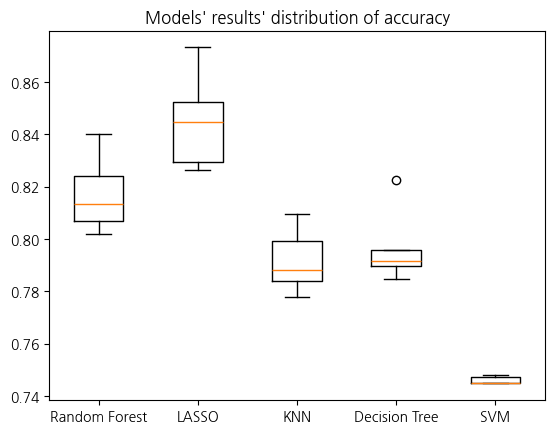

In [78]:
matplotlib.pyplot.boxplot(results, labels=names)
matplotlib.pyplot.title("Models' results' distribution of accuracy")
matplotlib.pyplot.show()

In [79]:
model = lm.LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000, random_state=config_dict['seed'])
params = {"C": np.linspace(start=0.001, stop=10, num=20)}
grid_search = GridSearchCV(model, params, scoring='accuracy')
grid_search.fit(x_features_train, y_labels_train)
print("최적의 하이퍼파라미터 'C' 값은:", grid_search.best_params_["C"])

/opt/anaconda3/envs/pyconda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/opt/anaconda3/envs/pyconda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/opt/anaconda3/envs/pyconda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=

최적의 하이퍼파라미터 'C' 값은: 2.1060526315789474


/opt/anaconda3/envs/pyconda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/opt/anaconda3/envs/pyconda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/opt/anaconda3/envs/pyconda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=

In [80]:
model = lm.LogisticRegression(C=grid_search.best_params_["C"], max_iter=1000, random_state=config_dict['seed'])
model.fit(x_features_train, y_labels_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",2.1060526315789474
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",0
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- Fo

In [81]:
y_train_estimated = model.predict(x_features_train)
accuracy_train = np.mean(y_train_estimated == y_labels_train)
baseline_accuracy_train = np.mean(0 == y_labels_train)
accuracy_lift_train = 100 * (accuracy_train / baseline_accuracy_train - 1)
print("전통적인 머신러닝 훈련 세트 결과:\n-------------------------")
print("기준 모델(더미 분류기) 정확도:", round(baseline_accuracy_train, 2))
print("현재 모델의 정확도:", round(accuracy_train, 2))
print("정확도 향상은:", round(accuracy_lift_train), "%")

전통적인 머신러닝 훈련 세트 결과:
-------------------------
기준 모델(더미 분류기) 정확도: 0.74
현재 모델의 정확도: 0.88
정확도 향상은: 18 %


In [82]:
y_test_estimated = model.predict(x_features_test)
accuracy_test = np.mean(y_test_estimated == y_labels_test)
baseline_accuracy_test = np.mean(0 == y_labels_test)
accuracy_lift = 100 * (accuracy_test / baseline_accuracy_test - 1)
print("전통적인 ML 모델의 테스트 세트 결과:\n-------------------------")
print("기준선(더미 분류기) 정확도:", round(baseline_accuracy_test, 2))
print("현재 모델의 정확도:", round(accuracy_test, 2))
print("정확도 향상률:", round(accuracy_lift), "%")
print("\n혼동 행렬:")
print(confusion_matrix(y_labels_test, y_test_estimated))
print("\n분류 보고서:")
print(classification_report(y_labels_test, y_test_estimated))

전통적인 ML 모델의 테스트 세트 결과:
-------------------------
기준선(더미 분류기) 정확도: 0.75
현재 모델의 정확도: 0.85
정확도 향상률: 13 %

혼동 행렬:
[[1504  128]
 [ 196  341]]

분류 보고서:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1632
           1       0.73      0.64      0.68       537

    accuracy                           0.85      2169
   macro avg       0.81      0.78      0.79      2169
weighted avg       0.85      0.85      0.85      2169



In [83]:
df = dataset_df_binary.copy()
dataset_df_binary = dataset_df_binary.rename(columns={"_label_": "label"})

In [84]:
labels = list(dataset_df_binary["label"].unique())

from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
language_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(labels))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [85]:
print(f"모델의 토큰 어휘 사전 크기: {language_model.config.vocab_size}")

모델의 토큰 어휘 사전 크기: 30522


In [86]:
test_df = dataset_df_binary.sample(frac=config_dict['test_size'], random_state=config_dict['seed'])
train_df = dataset_df_binary.drop(test_df.index)
train_eval_df = train_df.sample(frac=config_dict['test_size'], random_state=config_dict['seed'])
train_train_df = train_df.drop(train_eval_df.index)
dataset_train_train = Dataset.from_pandas(train_train_df)
dataset_train_eval = Dataset.from_pandas(train_eval_df)
dataset_test = Dataset.from_pandas(test_df)

In [87]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


train_train_tokenized = dataset_train_train.map(tokenize_function, batched=True)
train_eval_tokenized = dataset_train_eval.map(tokenize_function, batched=True)
test_tokenized = dataset_test.map(tokenize_function, batched=True)

Map: 100%|██████████| 2169/2169 [00:00<00:00, 14979.39 examples/s]


In [88]:
if layers_to_fine_tune == "head":
    print("분류 헤드만 미세 조정합니다!")
    language_model.train()
    for name, param in language_model.named_parameters():
        if 'classifier' not in name:
            param.requires_grad = False
else:
    print("전체 신경망을 미세 조정합니다!")

전체 신경망을 미세 조정합니다!


In [89]:
metric = evaluate.load("accuracy")

In [90]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [91]:
trainer = Trainer(
    model=language_model,
    args=lm_training_args,
    train_dataset=train_train_tokenized,
    eval_dataset=train_eval_tokenized,
    compute_metrics=compute_metrics,
)

In [92]:
trainer.train()

/opt/anaconda3/envs/pyconda/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Accuracy
100,0.398700,0.296867,0.880762
200,0.219700,0.306664,0.909650
300,0.265100,0.271525,0.922557
400,0.239800,0.379364,0.897972
500,0.223600,0.232091,0.933620
600,0.201800,0.209153,0.939766
700,0.098300,0.285865,0.934849
800,0.095100,0.263539,0.941610
900,0.106900,0.270975,0.940381
1000,0.073800,0.275300,0.942225


/opt/anaconda3/envs/pyconda/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs/pyconda/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs/pyconda/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs/pyconda/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs/pyconda/lib/python3.12/site-packages/tor

TrainOutput(global_step=1220, training_loss=0.18346458355911444, metrics={'train_runtime': 2757.5452, 'train_samples_per_second': 3.539, 'train_steps_per_second': 0.442, 'total_flos': 2567963900313600.0, 'train_loss': 0.18346458355911444, 'epoch': 2.0})

In [93]:
training_logs_df = pd.DataFrame(trainer.state.log_history).groupby("step", as_index=False).first()

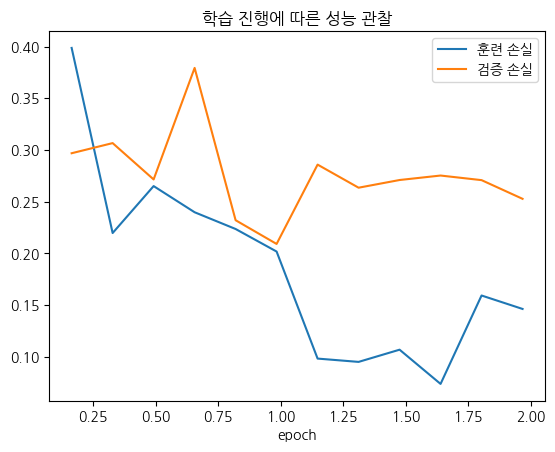

In [94]:
import matplotlib.pyplot as plt

training_logs_df.plot(x="epoch", y=["loss", "eval_loss"])
plt.title('학습 진행에 따른 성능 관찰')
plt.legend(['훈련 손실', '검증 손실'], loc='upper right')
plt.show()

In [95]:
results_train_train = trainer.predict(train_train_tokenized)  #
predictions_train_train = np.argmax(results_train_train[0], axis=-1)
accuracy_dl_train = np.mean(predictions_train_train == train_train_df["label"])
baseline_accuracy_dl_train = np.mean(most_frequent_class == train_train_df["label"])
accuracy_dl_lift_train = 100 * (accuracy_dl_train / baseline_accuracy_dl_train - 1)
print("딥러닝 언어 모델의 훈련 세트 결과:\n-------------------------------------------")
print("기준 모델(더미 분류기) 정확도:", round(baseline_accuracy_dl_train, 2))
print("현재 모델의 정확도:", round(accuracy_dl_train, 2))
print("정확도 향상은:", round(accuracy_dl_lift_train), "%")

/opt/anaconda3/envs/pyconda/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


딥러닝 언어 모델의 훈련 세트 결과:
-------------------------------------------
기준 모델(더미 분류기) 정확도: 0.74
현재 모델의 정확도: 0.99
정확도 향상은: 33 %


In [96]:
results_test = trainer.predict(test_tokenized)
predictions_test = np.argmax(results_test[0], axis=-1)
accuracy_dl_test = np.mean(predictions_test == test_df["label"])
baseline_accuracy_dl_test = np.mean(most_frequent_class == test_df["label"])
accuracy_dl_lift = 100 * (accuracy_dl_test / baseline_accuracy_dl_test - 1)
print("딥러닝 언어 모델의 테스트 세트 결과:\n---------------------------------------------------")
print("기준 모델(더미 분류기) 정확도:", round(baseline_accuracy_dl_test, 2))
print("현재 모델의 정확도:", round(accuracy_dl_test, 2))
print("정확도 향상은:", round(accuracy_dl_lift), "%")
print("\n혼동 행렬(Confusion Matrix):")
print(confusion_matrix(test_df["label"], predictions_test))
print("\n분류 보고서(Classification Report):")
print(classification_report(test_df["label"], predictions_test))

/opt/anaconda3/envs/pyconda/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


딥러닝 언어 모델의 테스트 세트 결과:
---------------------------------------------------
기준 모델(더미 분류기) 정확도: 0.75
현재 모델의 정확도: 0.95
정확도 향상은: 26 %

혼동 행렬(Confusion Matrix):
[[1570   62]
 [  48  489]]

분류 보고서(Classification Report):
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1632
           1       0.89      0.91      0.90       537

    accuracy                           0.95      2169
   macro avg       0.93      0.94      0.93      2169
weighted avg       0.95      0.95      0.95      2169

